In [3]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import random
import math
import scipy
from scipy import stats
from random import choice
import networkx as nx
import json
from networkx.readwrite import json_graph
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [4]:
import findspark
import os
findspark.init()
# import pyspark
# sc = pyspark.SparkContext()

In [5]:
# Load network graph
with open("../code/graph/nc_mini.json", "r") as graph_data:
    graph_data = json.load(graph_data)
    NC_digraph = json_graph.node_link_graph(graph_data)

In [6]:
def swapnodes(Nodes, graph):
    indices = range(len(Nodes))
    
    # take a random index to swap from the nodes
    n1 = np.random.choice(indices, 1)
    swapped_node = Nodes[n1[0]]
    
    # take a random index to swap from the whole graph
    n2 = np.random.choice(graph.nodes(), 1)
        
    # We check that we are not choosing the same node we just swapped
    while n2 == swapped_node:
        n2 = np.random.choice(graph.nodes(), 1)
    
    Nodes[n1] = n2[0]
    
    return Nodes

In [37]:
def activateNodesOptSN(detStartNodes):

    explored = set()
    activated = set()
    nodes = []
    for node in detStartNodes:
        nodes.append(node)
        activated.add(node)
    
    start = detStartNodes[0]
    successors = []

    while len(nodes)>0:

        startNode = nodes[0]

        if startNode not in explored:

            explored.add(startNode)

            successors = []
            for succNode in NC_digraph.succ[startNode]:

                if succNode not in activated:

                    alpha = NC_digraph[startNode][succNode]['weight']
                    beta = NC_digraph.node[succNode]['review_count']

                    if random.uniform(0,1) < np.sqrt(random.beta(alpha, beta)):
                        if succNode not in explored:
                            activated.add(succNode)
                            successors.append(succNode)

        nodes = nodes[1:]
        nodes = nodes + successors

    return len(activated)

def activateNodesLoopSN(N, startNodes):
    random.seed()
    iterations = sc.parallelize(xrange(N), 4)
    activatedNodes = iterations.map(lambda x: (activateNodesOptSN(startNodes)))
    
    return activatedNodes.mean()

In [38]:
# TODO
def simulated_annealing_tsp(function, initial_X, graph, N, initial_temp, cool, reanneal, iterr):
    
    accepted = 0
    X = initial_X
    T = initial_temp
    
    history = list()
    # Evaluate E
    #print distance(X)
    prev_E = function(N, X)
    history.append(prev_E)
    
    for i in xrange(iterr):
        # Stepsize
#         L = int(np.ceil(T))
        # Propose new x1 and x2 - Metropolis Algo.
        X_star = swapnodes(X, graph)
        # Evaluate E
        new_E = function(N, X_star) 
        delta_E = prev_E - new_E
        
        # Flip a coin
        U = np.random.uniform()
        if U < np.exp(-delta_E / T):
            accepted += 1
            history.append(new_E)
            # Copy X_star to X
            X = X_star
            prev_E = new_E

        # Check to cool down
        if accepted % reanneal == 0:
            T *= cool
            if T < 0.001: # Reheat
                T = 2.
            
    return X, history


In [70]:
import time
startNodes = random.choice(NC_digraph.nodes(),3)
initial_temp = 2.0
cool = 0.9
reanneal = 20
iterr = 1000
N = 500
t0 = time.time()
path,history = simulated_annealing_tsp(activateNodesLoopSN, startNodes, NC_digraph, N,  initial_temp, cool, reanneal, iterr)
print time.time() - t0

1604.29308701


[u'uBUGZtTxmaG-8YpUWpU5_Q' u'nykberdxcTFvdBf8lMOPJg'
 u'y57yAzmqx5cR0cfeFE91Sg']


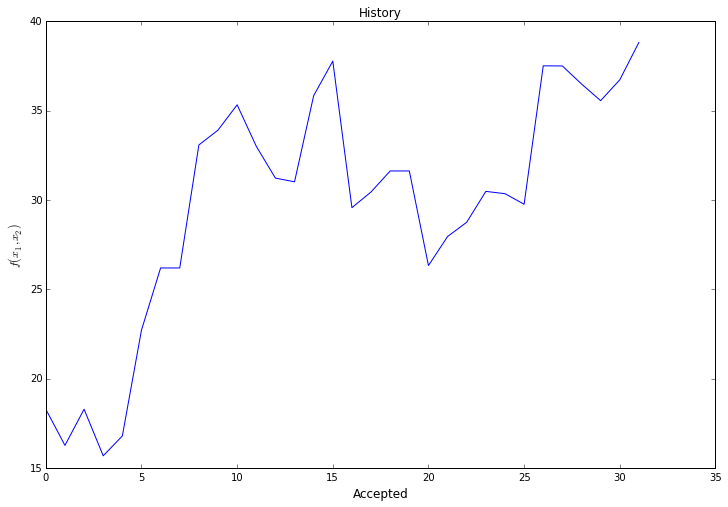

In [71]:
print path
plt.figure(figsize=(12,8))
plt.plot(history)
plt.title("History")
plt.ylabel("$f(x_1,x_2)$",fontsize=12)
plt.xlabel("Accepted", fontsize=12)
plt.show()
#ts3, vh,

In [61]:
import json
with open('data500_3000_T2.txt', 'w') as outfile:
    json.dump([str(path), history], outfile)